# High Accuracy Cancer Prediction Using Machine Learning Inspired Mass Spectrum Analysis

###### Peter Liu 6/11/2018

This is a set of mass spectra of samples from cancer patients and healthy people. We would like to compare ML model performance on prediction of cancer based on mass spectra and if possible, what kind of cancer

Data are downloaded from https://home.ccr.cancer.gov/ncifdaproteomics/ppatterns.asp

- Ovarian cancer dataset (Ovarian Dataset 8-7-02.zip):

Samples were prepared by robotic sample handling (washing, incubation, etc) and the spectra were generated by PBSII SELDI-TOF mass spectrometer. The sample set included 91 controls and 162 ovarian cancers.

-  Prostate cancer dataset (JNCI Dataset 7-3-02.zip)

This data was collected using the H4 protein chip and a Ciphergen PBS1 SELDI-TOF mass spectrometer. The chip was prepared by hand using the recommended protocol. The spectra were exported with the baseline subtracted. The goal of this feasibility study was to explore the existence of low molecular weight information that could serve as a diagnostic classifier, using a defined study set as a test ground.

# Data Wrangling 

## 1. Data Import, Cleaning and Transformation (Trial with single file)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
% matplotlib inline

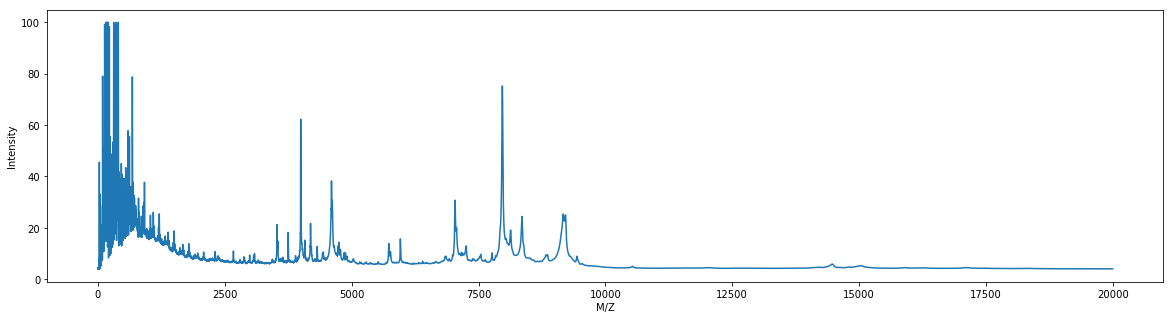

In [2]:
# Read cancer spectrum into pd dataframe
df = pd.read_csv('Database used\OvarianDataset_Robotic Handled\Cancer\Ovarian Cancer daf-0601.csv')

# Plot the Mass Spectrum
plt.figure(figsize=[20,5])
plt.plot(df['M/Z'], df['Intensity'])
plt.xlabel('M/Z')
plt.ylabel('Intensity')

#### Step 1. The mass less than 200 (matrix interference) and mass over 10000 provide weak or no influence on results, so I removed points in the above region

In [3]:
# Select regions where 200 < M/Z < 10000
df = df[(df['M/Z']>200) & (df['M/Z']<10000)]
df.head()

,M/Z,Intensity
1517,200.17821,100.000000
1518,200.44238,100.000000
1519,200.70672,100.000000
1520,200.97123,99.929613
1521,201.23592,99.702363


#### Step 2. Baseline substraction: Subtracted in a window the median of the 20% smallest values

In [4]:
# Compute the median value of the 20% smallest values
median = np.median(np.sort(df.Intensity)[:(len(df.Intensity)//5)])
print('The median intensity of the 20% smallest intensity is: {}'.format(median))

# Construct new data frame using updated Intensity
df.Intensity = df.Intensity.apply(lambda x: x-median if (x-median)>=0 else 0)

df.head()

The median intensity of the 20% smallest intensity is: 6.1987597


,M/Z,Intensity
1517,200.17821,93.801240
1518,200.44238,93.801240
1519,200.70672,93.801240
1520,200.97123,93.730853
1521,201.23592,93.503603


#### Step 3. Re-scaling and taking the square root: The spectra were divided by the median of the 5% top values, and the square root of the all values was taken.

In [5]:
# Compute the median value of the top 5% intensity values
top_median = np.median(np.sort(df.Intensity)[::-1][:(int(len(df.Intensity)*0.05))])
print('The median intensity of the top 5% intensity is: {}'.format(top_median))

# Construct new data frame using updated Intensity
df.Intensity = df.Intensity.apply(lambda x: x/top_median)
df.Intensity = np.sqrt(df.Intensity)

df.head()

The median intensity of the top 5% intensity is: 31.6866098


,M/Z,Intensity
1517,200.17821,1.720546
1518,200.44238,1.720546
1519,200.70672,1.720546
1520,200.97123,1.719901
1521,201.23592,1.717815


#### Step 4. Some intuitive plotting and imaging the sepctrum data
The more yellow the region is, the higher intensity of the M/Z. Notice that there are several regions of dark blue indicating that the intensity is essentially 0.

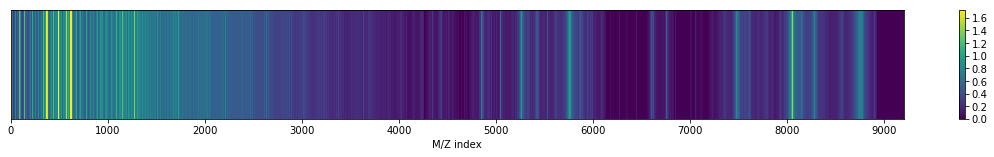

In [137]:
# Plot the heatmap of M/Z ratio of mass spectrum
plt.figure(figsize=[20,2])
plt.imshow(df.Intensity[np.newaxis,:], aspect="auto")
plt.yticks([])
plt.xticks(np.arange(0, 10000, 1000))
plt.colorbar()
plt.xlabel('M/Z index')

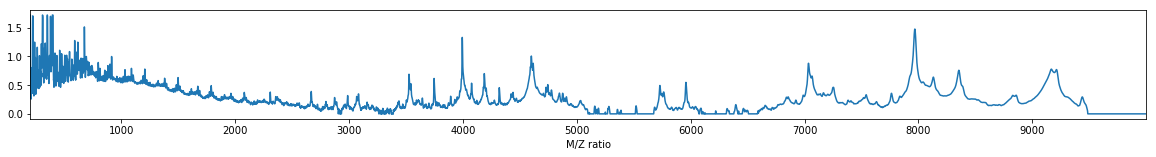

In [7]:
# Plot modified mass spectrum
plt.figure(figsize=[20,2])
plt.plot(df['M/Z'], df.Intensity)
plt.xlabel('M/Z ratio')
plt.xlim(200, 10000)
_ = plt.xticks(np.arange(1000, 10000, 1000))

#### Step 5. Transform the dataframe to a 'wider' form

In [8]:
# Pivot the dataframe, making the dataframe a 'wider' form
df_transform= df.pivot_table(columns='M/Z')
df_transform = df_transform.reset_index().iloc[:,1:]

In [9]:
# A wide format of M/Z ratio
df_transform

M/Z,200.17821,200.44238,200.70672,200.97123,201.23592,201.50078,201.76582,202.03103,202.29642,202.56198,...,9982.7063,9984.5713,9986.4364,9988.3017,9990.1672,9992.0328,9993.8987,9995.7647,9997.6308,9999.4972
0,1.720546,1.720546,1.720546,1.719901,1.717815,1.713023,1.692505,1.672132,1.63622,1.560843,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2. Data Import, Cleaning, Transformation and Concat (Mutiple files)

#### Step 1. Define methods to transform single spectrum file and combine multiple spectrum files

In [10]:
# Define methods to transform single csv file to wider form
def data_transform(path):
    # Read csv file
    df = pd.read_csv(path)
    df.columns = ['M/Z', 'Intensity']
    
    # Select mass window between 200 and 10000
    df = df[(df['M/Z']>200) & (df['M/Z']<10000)]
    
    # Baseline substration. Substract the spectra with the median of lowest 20% intensity
    median = np.median(np.sort(df.Intensity)[:(len(df.Intensity)//5)])
    df.Intensity = df.Intensity.apply(lambda x: x-median if (x-median)>=0 else 0)
    
    # Rescale by dividing the intensity with the median of top 5% intensity and take the rootsqure
    top_median = np.median(np.sort(df.Intensity)[::-1][:(int(len(df.Intensity)*0.05))])
    df.Intensity = df.Intensity.apply(lambda x: x/top_median)
    df.Intensity = np.sqrt(df.Intensity)
    
    # Pivot table and return the resulting data frame
    df_transform= df.pivot_table(columns='M/Z')
    df_transform = df_transform.reset_index().iloc[:,1:]
    
    return df_transform

In [11]:
# Define methods to transform and concat all dataframe to one single dataframe
def transform_combine_spectra(folder):    
    csv_list = glob.glob('Database used\\'+ folder + '\**\*.csv', recursive=True)
    df = pd.DataFrame()
    for csv_file in csv_list:
        temp = data_transform(csv_file)
        df_update = pd.concat((df, temp), ignore_index=True)
        if np.any(df.isnull()):
            print('There is mismatch of data points!')
            break
        else:
            df = df_update
    return df

#### Step 2. Create ovarian data

In [12]:
# Spectra data for cancer group
cancer_group = transform_combine_spectra('OvarianDataset_Robotic Handled\Cancer')

In [13]:
# Spectra data for non cancer group
control_group = transform_combine_spectra('OvarianDataset_Robotic Handled\Control')

#### Step 3. Create prostate data

In [14]:
# Spectra data for cancer group
cancer_group_prostate = transform_combine_spectra('JNCI_Data_7-3-02\Cancer')

In [15]:
# Spectra data for non cancer group
control_group_prostate = transform_combine_spectra('JNCI_Data_7-3-02\Control')

# Exploratary Data Analysis (EDA) of two data set

In [16]:
# Define method of creating data and labels
def create_data_label(cancer_group, control_group):
    data = pd.concat((cancer_group, control_group), ignore_index=True)
    label = np.concatenate((np.repeat(1, cancer_group.shape[0]), np.repeat(-1, control_group.shape[0])))
    return data, label

In [141]:
# Define method of plotting spectra heatmap
def heatmap(cancer_group, control_group):
    plt.figure(figsize=[20,10])

    # Cancer group spectra
    plt.subplot(211)
    plt.title('Cancer group')

    plt.imshow(cancer_group, aspect='auto')
    plt.xticks(np.arange(0, 10000, 1000))
    plt.yticks(np.arange(0,len(cancer_group)+1, 10))
    plt.xlabel('M/Z index')
    plt.ylabel('Samples')
    plt.colorbar()

    # Non-cancer group spectra
    plt.subplot(2,1,2)
    plt.title('Control group')
    plt.imshow(control_group, aspect='auto')
    plt.xticks(np.arange(0, 10000, 1000))
    plt.yticks(np.arange(0,len(control_group),10))
    plt.xlabel('M/Z index')

    plt.ylabel('Samples')
    plt.colorbar()

    plt.tight_layout()

In [18]:
# Create data and labels for ovarian and prostate samples
ovarian_data, ovarian_label = create_data_label(cancer_group, control_group)
prostate_data, prostate_label = create_data_label(cancer_group_prostate, control_group_prostate)

### 1. Visualization of mass spectra for ovarian samples and prostate samples
We can easily tell that the spectra for ovarian samples are significantly different from prostate samples. For ovarain samples, lower molecular weight (< 1000) has higher intensity, while higher molecular weight (> 5000) has higher intensity in prostate samples.

* Spetra heamap of ovarian samples

Ovarian Samples


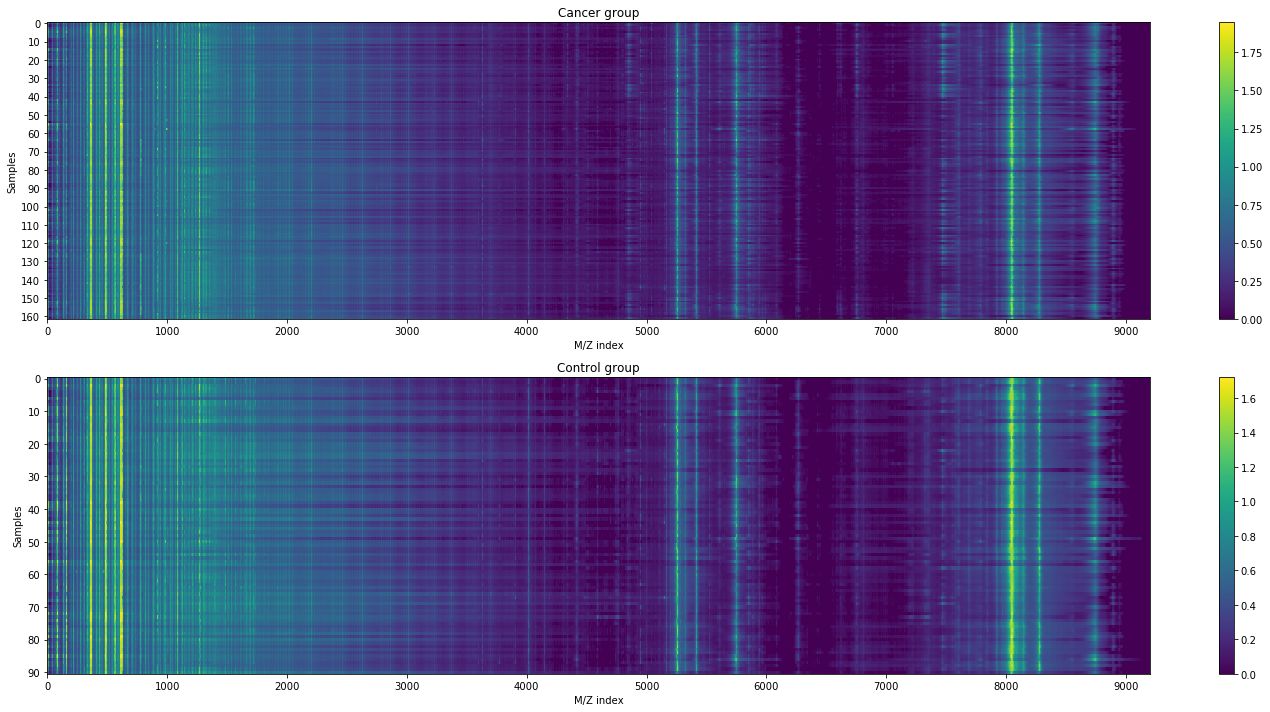

In [142]:
print('Ovarian Samples')
print('='*100)
heatmap(cancer_group, control_group)

* Spectra heatmap of prostate samples

Prostate Samples


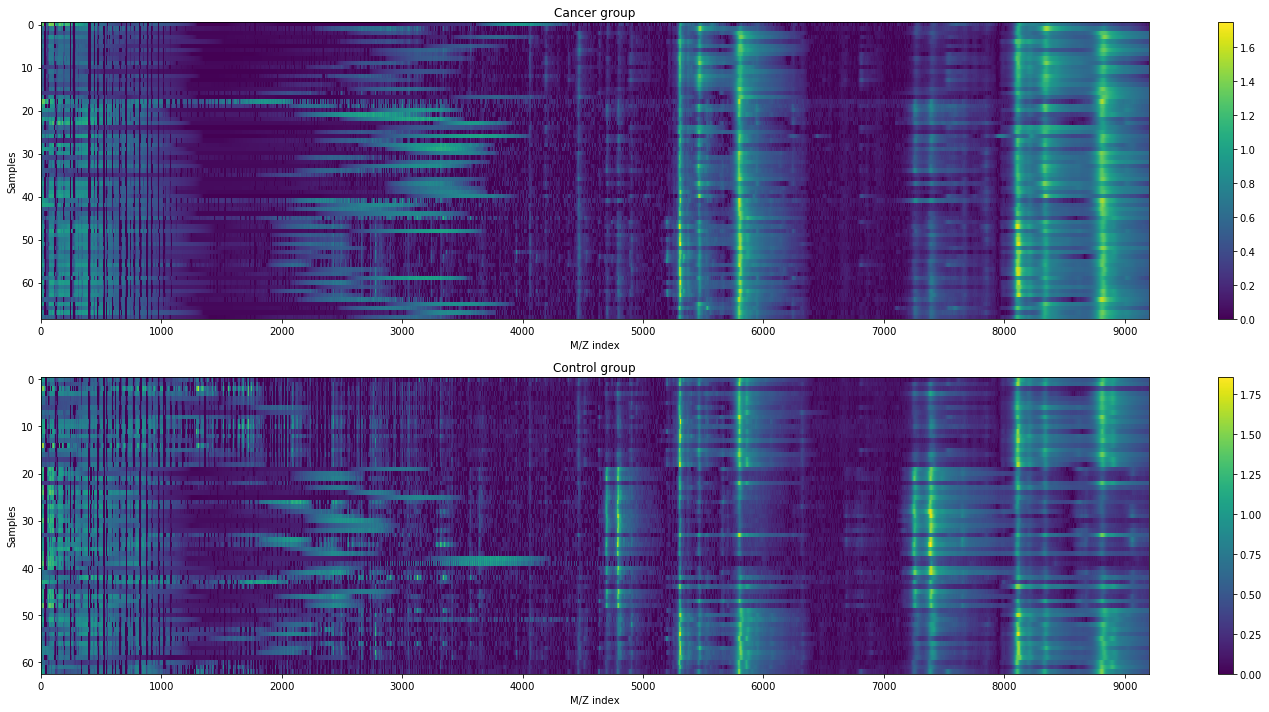

In [143]:
print('Prostate Samples')
print('='*100)
heatmap(cancer_group_prostate, control_group_prostate)

### 2. PCA Transformation and Visualization

We are facing a dataset with significantly larger features than samples. This is common for all spectra data, where it is relatively difficult to collect large amount of samples through experiments, but it was fairly easy to obtain tons of features or datapoints through spectroscopy analysis.

Before we do any further analysis, explortary data analysis (EDA) is necessary to evaluate the dataset (e.g., complexicity and data quality). Herein, we would like to visualize the data distribution using the first two principle components.

#### For ovarian samples
The first two components explained almost 60% variance of data, and the fist 20 components explained almost 95% variance of data
From the scatterplot of the first two principle components, cancer and non-cancer samples could be reasonably separated

#### For prostate samples
The first two principle compoents explained only 45% variance of data, and it needs the 44 components to explain 95% variance. Cancer and non-cancer samples could also be well separated using the first two principle components


In [21]:
from sklearn.decomposition import PCA
pca = PCA()
pca_prostate = PCA()

In [22]:
ovarian_data_transform = pca.fit_transform(ovarian_data)
prostate_data_transform = pca_prostate.fit_transform(prostate_data)

Variance explained ratio of ovarian and prostate samples

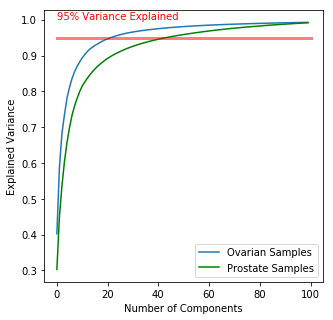

In [23]:
# Show the cumulative explained variance
plt.figure(figsize=[5,5])
plt.plot(np.cumsum(pca.explained_variance_ratio_)[:100], label= 'Ovarian Samples')
plt.plot(np.cumsum(pca_prostate.explained_variance_ratio_)[:100], 'g', label= 'Prostate Samples')
plt.plot([0,100], [0.95, 0.95], color = 'r', linewidth = 3, alpha = 0.5)
plt.annotate('95% Variance Explained', xy=(0,1), xytext=(0,1), color = 'r')
plt.legend(loc = 'best')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')

Comparison of cancer classification using first two principle components of ovarian samples and prostate samples

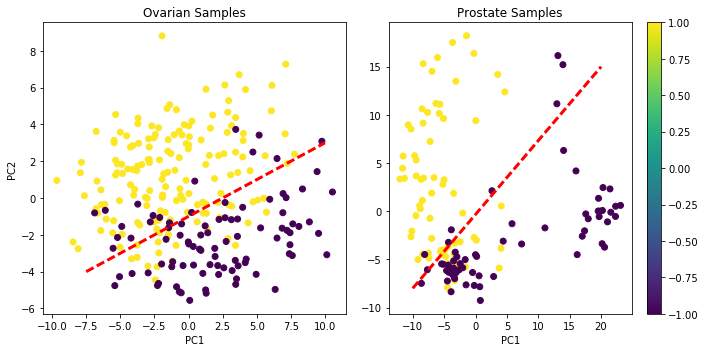

In [24]:
# Scatter plot of PC1 and PC2
plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
plt.title('Ovarian Samples')
plt.scatter(ovarian_data_transform[:,0], ovarian_data_transform[:,1], c=ovarian_label)
plt.plot([-7.5,10],[-4, 3],'r--',linewidth = 3)
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.subplot(1,2,2)
plt.title('Prostate Samples')
plt.scatter(prostate_data_transform[:,0], prostate_data_transform[:,1], c=prostate_label)
plt.plot([-10,20],[-8, 15],'r--',linewidth = 3)
plt.xlabel('PC1')
plt.colorbar()

plt.tight_layout()


# Deep Analysis using Machine Learning Algorithm

Support vector machine was often used in classification of spectra data, because it has strong capacity in handling high-dimension data. Herein, we started with SVM as the benchmark classification method for modeling and predicting cancer

### 1. Define methods for generate performance report of model

In [25]:
def report(model, y, predict):
    print('Report of ' + model)
    print('=================================================================================')
    print('Accuracy of the model:{}'.format(accuracy_score(y, predict)))
    print('AUC score:            {}'.format(roc_auc_score(y, predict)))
    print('F1 score:             {}'.format(f1_score(y, predict)))

### 2. Feature Selection using Random Forest

Decision Tree is a natural way of feature selection. Tree split is based on gain of gini impurity, so tree always splits towards more important features. Random forest algorithom is ensemble method using tree bagging and random feature selection for each split. Herein, we used Random Forest to select the most important features. We set the thresold is 95%, meaning the most important features could explain more than 95% variance of dataset in total

In [26]:
# Import random forest from sklearn.ensemble
from sklearn.ensemble import RandomForestClassifier

In [27]:
# Select number of features (from high importance to low importance) with total importance more than 95%
def feature_number(feature_importance):
    feature_importance_sort = np.sort(feature_importance)[::-1]
    sums = 0
    for i, j in enumerate(feature_importance_sort):
        sums += j
        if sums>0.9:
            return(i+1)

#### Fit ovarian and prostate data using random forest

In [28]:
# Fit the model using Random Forest
rf_ovarian = RandomForestClassifier(random_state=4)
rf_prostate = RandomForestClassifier(random_state=5)
rf_ovarian.fit(ovarian_data, ovarian_label)
rf_prostate.fit(prostate_data, prostate_label)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=5,
            verbose=0, warm_start=False)

#### Plot the cumulative explained variance of features

It is noted that within 9200 features(M/Z), using only 40 features(0.43% of total features) can explain more than 95% variance for prostate samples, and 52 features (0.58% of total features) will explain more than 95% variance for ovarian samples. Feature selection will significantly reduce the noise features

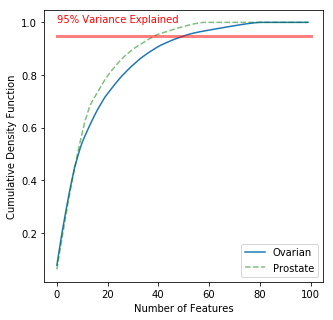

In [29]:
# Plot the cumulative explained variance of features
feature_importance_ovarian = rf_ovarian.feature_importances_
feature_importance_prostate = rf_prostate.feature_importances_

plt.figure(figsize=(5,5))
plt.plot(np.cumsum(np.sort(feature_importance_ovarian)[::-1][:100]), label = 'Ovarian')
plt.plot(np.cumsum(np.sort(feature_importance_prostate)[::-1][:100]), 'g--', alpha = 0.5, label ='Prostate')

plt.plot([0,100], [0.95, 0.95], color = 'r', linewidth = 3, alpha = 0.5)
plt.annotate('95% Variance Explained', xy=(0,1), xytext=(0,1), color = 'r')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Density Function')
plt.legend(loc='best')

In [30]:
# Select indexes of top features explaining 95% of variance
important_feature_index_ovarian = np.argsort(feature_importance_ovarian)[::-1][:(feature_number(feature_importance_ovarian))]
important_feature_index_prostate = np.argsort(feature_importance_prostate)[::-1][:(feature_number(feature_importance_prostate))]

In [31]:
# Select import mass for ovarian and prostate data
mass_important_ovarian = ovarian_data.columns[important_feature_index_ovarian]
mass_important_prostate = prostate_data.columns[important_feature_index_prostate]

#### Distribution of important mass for ovarian and prostate. 
For ovarian data:

The most important M/Z were mainly molecules with small molecular weight below 1000. Region between 1000-3000 has week or no significant importance.

For prostate data:
The most important M/Z were more spread out than ovarian data.

(array([ 10.,  10.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   1.,   0.,   7.,   0.,   0.,   0.,   0.,   3.,   0.,
          4.,   0.,   0.,   0.,   0.,   0.,   1.,   1.]),
 array([  245.8296 ,   549.95378,   854.07796,  1158.20214,  1462.32632,
         1766.4505 ,  2070.57468,  2374.69886,  2678.82304,  2982.94722,
         3287.0714 ,  3591.19558,  3895.31976,  4199.44394,  4503.56812,
         4807.6923 ,  5111.81648,  5415.94066,  5720.06484,  6024.18902,
         6328.3132 ,  6632.43738,  6936.56156,  7240.68574,  7544.80992,
         7848.9341 ,  8153.05828,  8457.18246,  8761.30664,  9065.43082,
         9369.555  ]),
 <a list of 30 Patch objects>)

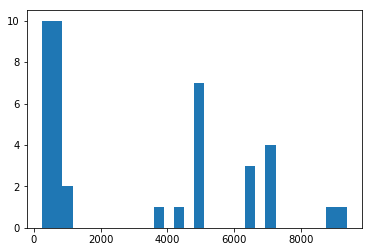

In [32]:
# Important mass distribution for ovarian data
plt.hist(mass_important_ovarian, bins=30)

(array([ 2.,  9.,  1.,  0.,  1.,  1.,  1.,  0.,  0.,  3.,  3.,  1.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  3.,  0.,  2.,  0.,  0.,  0.,
         1.,  0.,  0.,  2.]),
 array([  322.08531 ,   642.553763,   963.022216,  1283.490669,
         1603.959122,  1924.427575,  2244.896028,  2565.364481,
         2885.832934,  3206.301387,  3526.76984 ,  3847.238293,
         4167.706746,  4488.175199,  4808.643652,  5129.112105,
         5449.580558,  5770.049011,  6090.517464,  6410.985917,
         6731.45437 ,  7051.922823,  7372.391276,  7692.859729,
         8013.328182,  8333.796635,  8654.265088,  8974.733541,
         9295.201994,  9615.670447,  9936.1389  ]),
 <a list of 30 Patch objects>)

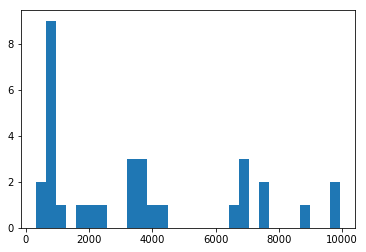

In [33]:
# Important mass distribution for prostate data
plt.hist(mass_important_prostate, bins=30)

### 3. Modeling using different algorithm (SVM, Random Forest, and KNN)

In [34]:
# Split the data to training and testing data
from sklearn.model_selection import train_test_split

x_train_ovarian, x_test_ovarian, y_train_ovarian, y_test_ovarian = train_test_split(ovarian_data.iloc[:,important_feature_index_ovarian], 
                                                                                    ovarian_label,
                                                                                    test_size = 0.3, 
                                                                                    random_state = 10)

x_train_prostate, x_test_prostate, y_train_prostate, y_test_prostate = train_test_split(prostate_data.iloc[:,important_feature_index_prostate], 
                                                                                    prostate_label,
                                                                                    test_size = 0.3, 
                                                                                    random_state = 10)

#### SVM

In [35]:
# Import necessary sklearn package for ML
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix, roc_auc_score, f1_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [36]:
# make pipeline using standard scale and svc
pipeline=make_pipeline(StandardScaler(), SVC())
param_grid = {'svc__C': 10.**np.arange(-3,3), 'svc__gamma': 10.**np.arange(-3,3)}

# Create gridsearch object to tune C and gammas values
gs = GridSearchCV(pipeline, param_grid=param_grid)

In [37]:
# Fit data and predict testing results for ovarian and prostate

# Ovarian data fit and predict
gs.fit(x_train_ovarian, y_train_ovarian)
svc_predict_ovarian = gs.predict(x_test_ovarian)

# Prostate data fit and predict
gs.fit(x_train_prostate, y_train_prostate)
svc_predict_prostate = gs.predict(x_test_prostate)

In [38]:
# Generate performance report
report('SVM with selected features for ovarian prediction', y_test_ovarian, svc_predict_ovarian)
print('\n')
print('='*100)
print('\n')
report('SVM with selected features for prostate prediction', y_test_prostate, svc_predict_prostate)

Report of SVM with selected features for ovarian prediction
Accuracy of the model:1.0
AUC score:            1.0
F1 score:             1.0




Report of SVM with selected features for prostate prediction
Accuracy of the model:0.975
AUC score:            0.9782608695652174
F1 score:             0.9777777777777777


#### Random Forest

In [39]:
# Tune parameters for random forest, using n_estimators and max_features to tune

param_grid = {'n_estimators': 10**np.arange(3), 
              'max_features': ['auto','sqrt','log2']}
gs = GridSearchCV(RandomForestClassifier(), param_grid=param_grid)
gs.fit(x_train_ovarian, y_train_ovarian)
rf_predict_ovarian = gs.predict(x_test_ovarian)

In [40]:
# Fit and predict prostate data
gs.fit(x_train_prostate, y_train_prostate)
rf_predict_prostate = gs.predict(x_test_prostate)

In [41]:
report('Random Forest with selected features for ovarian prediction', y_test_ovarian, rf_predict_ovarian)
print('\n')
print('='*100)
print('\n')
report('SVM with selected features for prostate prediction', y_test_prostate, rf_predict_prostate)

Report of Random Forest with selected features for ovarian prediction
Accuracy of the model:1.0
AUC score:            1.0
F1 score:             1.0




Report of SVM with selected features for prostate prediction
Accuracy of the model:0.925
AUC score:            0.9347826086956521
F1 score:             0.9302325581395349


#### KNN

In [42]:
# Tune parameters for random forest, using n_neighbors to tune

from sklearn.neighbors import KNeighborsClassifier
param_grid_knn = {'n_neighbors':np.arange(1,30)}
gs = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid_knn)

In [43]:
# Fit and predict ovarian
gs.fit(x_train_ovarian, y_train_ovarian)
knn_predict_ovarian = gs.predict(x_test_ovarian)

In [44]:
# Fit and predict prostate
gs.fit(x_train_prostate, y_train_prostate)
knn_predict_prostate = gs.predict(x_test_prostate)

In [45]:
# Generate knn performance report for ovarian and prostate data

report('knn ovarian', y_test_ovarian, knn_predict_ovarian)
print('\n')
print('='*100)
print('\n')
report('knn prostate', y_test_prostate, knn_predict_prostate)

Report of knn ovarian
Accuracy of the model:0.9868421052631579
AUC score:            0.9897959183673469
F1 score:             0.9896907216494846




Report of knn prostate
Accuracy of the model:1.0
AUC score:            1.0
F1 score:             1.0


### 4. Comparison of model performance of SVM, Random Forest, and KNN
It is noticed that for the prediction of both ovarian and prostate cancers, all ML models performs extremely well. For Ovarian data, Random Forest and SVM can achieve 100% accuracy. Meanwhile, for prostate data, knn can achieve 100% accuracy. However, we should not be too confident on our models, because we will need much larger data to optimize our model and test the model performance. Our model also has to be flexible, meaning it can deal with situations where more noise than usual appears in the mass spectrum (e.g., the impurities in the samples during sample preparation and instruments errors)

In [56]:
comparison = pd.DataFrame({'SVM':[1.0,1.0,1.0,0.98,0.98,0.98], 
                           'Random Forest':[1.0, 1.0, 1.0,0.93,0.93,0.93], 
                           'KNN':[0.99,0.99, 0.99,1.0, 1.0, 1.0],
                           'Score': ['Accuracy', 'AUC', 'F1-Score', 'Accuracy', 'AUC', 'F1-Score'],
                           'Data':  ['Ovarian','Ovarian','Ovarian', 'Prostate', 'Prostate', 'Prostate']}).set_index(['Data','Score'])
print(comparison)

                    KNN  Random Forest   SVM
Data     Score                              
Ovarian  Accuracy  0.99           1.00  1.00
         AUC       0.99           1.00  1.00
         F1-Score  0.99           1.00  1.00
Prostate Accuracy  1.00           0.93  0.98
         AUC       1.00           0.93  0.98
         F1-Score  1.00           0.93  0.98
